In [1]:
%matplotlib inline

In [2]:
import math
import torch
import torch.nn as nn
import torchvision
import numpy as np
import lightly

## Configuration

We set some configuration parameters for our experiment. 

The default configuration with a batch size and input resolution of 256

In [3]:
num_workers = 8
batch_size = 128
seed = 1
epochs = 50
input_size = 256

# dimension of the embeddings
num_ftrs = 512
# dimension of the output of the prediction and projection heads
out_dim = proj_hidden_dim = 512
# the prediction head uses a bottleneck architecture
pred_hidden_dim = 128
# use 2 layers in the projection head
num_mlp_layers = 2

In [4]:
# seed torch and numpy
torch.manual_seed(0)
np.random.seed(0)

# set the path to the dataset
path_to_data = 'birds/sample_train/'

## Setup data augmentations and loaders

In [5]:
# define the augmentations for self-supervised learning
collate_fn = lightly.data.ImageCollateFunction(
    input_size=input_size,
    # require invariance to flips and rotations
    hf_prob=0.5,
    vf_prob=0.5,
    rr_prob=0.5,
    # satellite images are all taken from the same height
    # so we use only slight random cropping
    min_scale=0.5,
    # use a weak color jitter for invariance w.r.t small color changes
    cj_prob=0.2,
    cj_bright=0.1,
    cj_contrast=0.1,
    cj_hue=0.1,
    cj_sat=0.1,
)

# create a lightly dataset for training, since the augmentations are handled
# by the collate function, there is no need to apply additional ones here
dataset_train_simsiam = lightly.data.LightlyDataset(
    input_dir=path_to_data
)

# create a dataloader for training
dataloader_train_simsiam = torch.utils.data.DataLoader(
    dataset_train_simsiam,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    drop_last=True,
    num_workers=num_workers
)

# create a torchvision transformation for embedding the dataset after training
# here, we resize the images to match the input size during training and apply
# a normalization of the color channel based on statistics from imagenet
test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((input_size, input_size)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=lightly.data.collate.imagenet_normalize['mean'],
        std=lightly.data.collate.imagenet_normalize['std'],
    )
])



# create a lightly dataset for embedding
dataset_test = lightly.data.LightlyDataset(
    input_dir=path_to_data,
    transform=test_transforms
)



# create a dataloader for embedding
dataloader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

## Create the SimSiam model

In [6]:
# we use a pretrained resnet for this tutorial to speed
# up training time but you can also train one from scratch
resnet = torchvision.models.resnet18()
backbone = nn.Sequential(*list(resnet.children())[:-1])

# create the SimSiam model using the backbone from above
model = lightly.models.SimSiam(
    backbone,
    num_ftrs=num_ftrs,
    proj_hidden_dim=pred_hidden_dim,
    pred_hidden_dim=pred_hidden_dim,
    out_dim=out_dim,
    num_mlp_layers=num_mlp_layers
)

In [7]:
# SimSiam uses a symmetric negative cosine similarity loss
criterion = lightly.loss.SymNegCosineSimilarityLoss()

# scale the learning rate 
lr = 0.05 * batch_size / 256
# use SGD with momentum and weight decay
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=lr,
    momentum=0.9,
    weight_decay=5e-4
)

## Train SimSiam

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

avg_loss = 0.
avg_output_std = 0.
for e in range(epochs):

    for (x0, x1), _, _ in dataloader_train_simsiam:

        # move images to the gpu
        x0 = x0.to(device)
        x1 = x1.to(device)

        # run the model on both transforms of the images
        # the output of the simsiam model is a y containing the predictions
        # and projections for each input x
        y0, y1 = model(x0, x1)

        # backpropagation
        loss = criterion(y0, y1)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        # calculate the per-dimension standard deviation of the outputs
        # we can use this later to check whether the embeddings are collapsing
        output, _ = y0
        output = output.detach()
        output = torch.nn.functional.normalize(output, dim=1)
        
        output_std = torch.std(output, 0)
        output_std = output_std.mean()

        # use moving averages to track the loss and standard deviation
        w = 0.9
        avg_loss = w * avg_loss + (1 - w) * loss.item()
        avg_output_std = w * avg_output_std + (1 - w) * output_std.item()

    # the level of collapse is large if the standard deviation of the l2
    # normalized output is much smaller than 1 / sqrt(dim)
    collapse_level = max(0., 1 - math.sqrt(out_dim) * avg_output_std)
    # print intermediate results
    print(f'[Epoch {e:3d}] '
        f'Loss = {avg_loss:.2f} | '
        f'Collapse Level: {collapse_level:.2f} / 1.00')

[Epoch   0] Loss = 0.00 | Collapse Level: 1.00 / 1.00
[Epoch   1] Loss = 0.00 | Collapse Level: 1.00 / 1.00
[Epoch   2] Loss = 0.00 | Collapse Level: 1.00 / 1.00
[Epoch   3] Loss = 0.00 | Collapse Level: 1.00 / 1.00
[Epoch   4] Loss = 0.00 | Collapse Level: 1.00 / 1.00
[Epoch   5] Loss = 0.00 | Collapse Level: 1.00 / 1.00
[Epoch   6] Loss = 0.00 | Collapse Level: 1.00 / 1.00
[Epoch   7] Loss = 0.00 | Collapse Level: 1.00 / 1.00
[Epoch   8] Loss = 0.00 | Collapse Level: 1.00 / 1.00
[Epoch   9] Loss = 0.00 | Collapse Level: 1.00 / 1.00
[Epoch  10] Loss = 0.00 | Collapse Level: 1.00 / 1.00
[Epoch  11] Loss = 0.00 | Collapse Level: 1.00 / 1.00
[Epoch  12] Loss = 0.00 | Collapse Level: 1.00 / 1.00
[Epoch  13] Loss = 0.00 | Collapse Level: 1.00 / 1.00
[Epoch  14] Loss = 0.00 | Collapse Level: 1.00 / 1.00
[Epoch  15] Loss = 0.00 | Collapse Level: 1.00 / 1.00
[Epoch  16] Loss = 0.00 | Collapse Level: 1.00 / 1.00
[Epoch  17] Loss = 0.00 | Collapse Level: 1.00 / 1.00
[Epoch  18] Loss = 0.00 | Co

## Scatter Plot and Nearest Neighbors

In [9]:
embeddings = []
filenames = []

# disable gradients for faster calculations
model.eval()
with torch.no_grad():
    for i, (x, _, fnames) in enumerate(dataloader_test):
        # move the images to the gpu
        x = x.to(device)
        # embed the images with the pre-trained backbone
        y = model.backbone(x)
        y = y.squeeze()
        # store the embeddings and filenames in lists
        embeddings.append(y)
        filenames = filenames + list(fnames)

# concatenate the embeddings and convert to numpy
embeddings = torch.cat(embeddings, dim=0)
embeddings = embeddings.cpu().numpy()

C:\Users\ideapad 330\.conda\envs\AIML\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [10]:
# for plotting
import os
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.offsetbox as osb
from matplotlib import rcParams as rcp

# for resizing images to thumbnails
import torchvision.transforms.functional as functional

# for clustering and 2d representations
from sklearn import random_projection

In [11]:
# for the scatter plot we want to transform the images to a two-dimensional
# vector space using a random Gaussian projection
projection = random_projection.GaussianRandomProjection(n_components=2)
embeddings_2d = projection.fit_transform(embeddings)

# normalize the embeddings to fit in the [0, 1] square
M = np.max(embeddings_2d, axis=0)
m = np.min(embeddings_2d, axis=0)
embeddings_2d = (embeddings_2d - m) / (M - m)

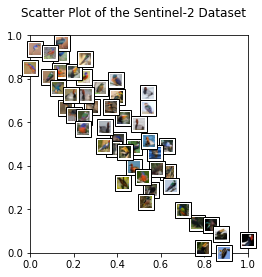

In [17]:
def get_scatter_plot_with_thumbnails():
    """Creates a scatter plot with image overlays.
    """
    # initialize empty figure and add subplot
    fig = plt.figure()
    fig.suptitle('Scatter Plot of the Sentinel-2 Dataset')
    ax = fig.add_subplot(1, 1, 1)
    # shuffle images and find out which images to show
    shown_images_idx = []
    shown_images = np.array([[1., 1.]])
    iterator = [i for i in range(embeddings_2d.shape[0])]
    np.random.shuffle(iterator)
    for i in iterator:
        # only show image if it is sufficiently far away from the others
        dist = np.sum((embeddings_2d[i] - shown_images) ** 2, 1)
        if np.min(dist) < 2e-3:
            continue
        shown_images = np.r_[shown_images, [embeddings_2d[i]]]
        shown_images_idx.append(i)

    # plot image overlays
    for idx in shown_images_idx:
        thumbnail_size = int(rcp['figure.figsize'][0] * 2.)
        path = os.path.join(path_to_data, filenames[idx])
        img = Image.open(path)
        img = functional.resize(img, thumbnail_size)
        img = np.array(img)
        img_box = osb.AnnotationBbox(
            osb.OffsetImage(img, cmap=plt.cm.gray_r),
            embeddings_2d[idx],
            pad=0.2,
        )
        ax.add_artist(img_box)

    # set aspect ratio
    ratio = 1. / ax.get_data_ratio()
    ax.set_aspect(ratio, adjustable='box')


# get a scatter plot with thumbnail overlays
get_scatter_plot_with_thumbnails()
plt.savefig('birds.png')

In [13]:
import random

In [14]:
l = os.listdir('birds/sample_train')
example_images = random.sample(l, 10)

In [15]:
example_images

['049.jpg',
 '023.jpg',
 '148.jpg',
 '099.jpg',
 '169.jpg',
 '070.jpg',
 '114.jpg',
 '075.jpg',
 '103.jpg',
 '139.jpg']

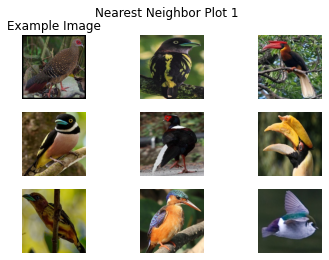

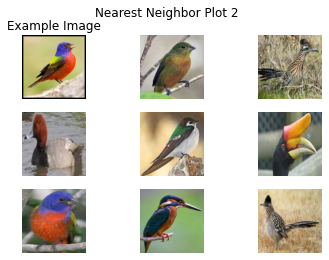

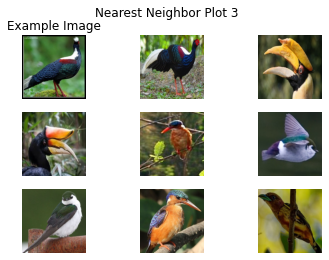

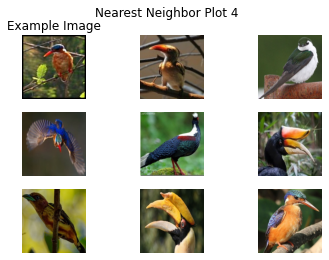

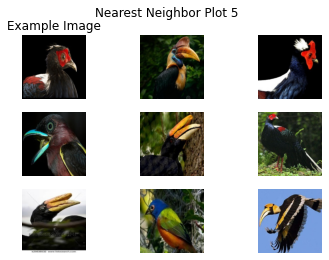

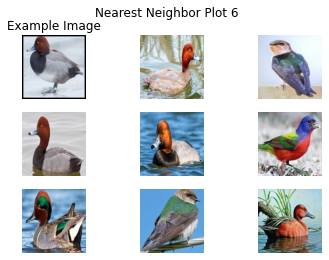

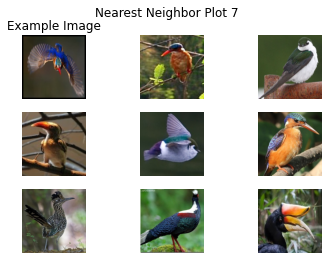

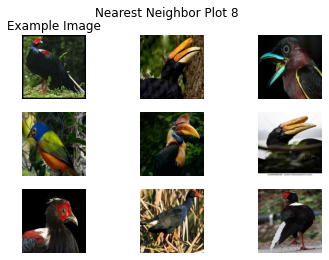

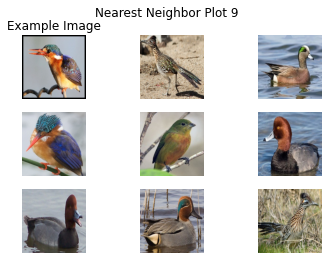

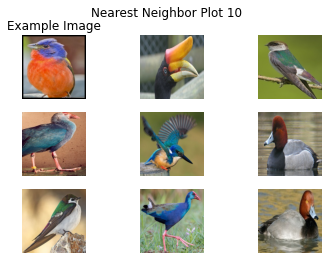

In [18]:
def get_image_as_np_array(filename: str):
    """Loads the image with filename and returns it as a numpy array.

    """
    img = Image.open(filename)
    return np.asarray(img)


def get_image_as_np_array_with_frame(filename: str, w: int = 5):
    """Returns an image as a numpy array with a black frame of width w.

    """
    img = get_image_as_np_array(filename)
    ny, nx, _ = img.shape
    # create an empty image with padding for the frame
    framed_img = np.zeros((w + ny + w, w + nx + w, 3))
    framed_img = framed_img.astype(np.uint8)
    # put the original image in the middle of the new one
    framed_img[w:-w, w:-w] = img
    return framed_img


def plot_nearest_neighbors_3x3(example_image: str, i: int):
    """Plots the example image and its eight nearest neighbors.

    """
    n_subplots = 9
    # initialize empty figure
    fig = plt.figure()
    fig.suptitle(f"Nearest Neighbor Plot {i + 1}")
    #
    example_idx = filenames.index(example_image)
    # get distances to the cluster center
    distances = embeddings - embeddings[example_idx]
    distances = np.power(distances, 2).sum(-1).squeeze()
    # sort indices by distance to the center
    nearest_neighbors = np.argsort(distances)[:n_subplots]
    # show images
    for plot_offset, plot_idx in enumerate(nearest_neighbors):
        ax = fig.add_subplot(3, 3, plot_offset + 1)
        # get the corresponding filename
        fname = os.path.join(path_to_data, filenames[plot_idx])
        if plot_offset == 0:
            ax.set_title(f"Example Image")
            plt.imshow(get_image_as_np_array_with_frame(fname))
        else:
            plt.imshow(get_image_as_np_array(fname))
        # let's disable the axis
        plt.axis("off")


# show example images for each cluster
for i, example_image in enumerate(example_images):
    plot_nearest_neighbors_3x3(example_image, i)
    plt.savefig(f'birds{i}.png')